<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [9]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [10]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20
deep_num = 3

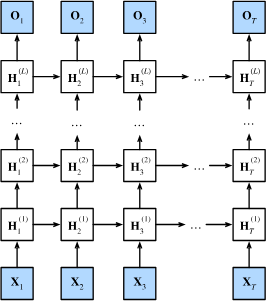

as the

In [18]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))
  def forward(self, x, h):
    h = torch.tanh(self.i2h(x) + self.h2h(h) + self.hb2)
    y = self.h2o(h) + self.ob
    return y, h


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size)
    self.rnn_list = nn.ModuleList([SimpleRNN(vocab_size, hidden_size) for _ in range(deep_num)])
  def forward(self, x, h_prev_list):
    x = self.embedding(x)
    h_list = []
    h = self.e2h(x)
    for i in range(self.deep_num):
      x, h = self.rnn_list[i](h, h_prev_list[i])
      h_list.append(h)
    return x, h_list

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, 3)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [19]:
def generateMiniBatch(start_idx):
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [13]:
stopi = []
lossi = []

In [ ]:
# Training loop
num_iterations = 10000
p = 0
for iteration in range(num_iterations):

  if p + seq_length + 1 > len(data):
    p = 0;

  inputs, targets = generateMiniBatch(p)

  optimizer.zero_grad()

  totalloss = 0
  hprev_list = [torch.zeros(1, 1, hidden_size) for _ in range(deep_num)]  # Reset RNN memory
  for i in range(seq_length):
    input_char = inputs[:,i].unsqueeze(1)
    output_char = targets[:,i]

    predict_char, hprev_list = model(input_char, hprev_list)

    loss = criterion(predict_char.squeeze(1), output_char)
    totalloss += loss.item()

    loss.backward()
    for i in range(deep_num):
      hprev_list[i] = hprev_list[i].detach()

    for param in model.parameters():
      if param.grad is not None:
        param.grad.data.clamp_(-5, 5)

    optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss/seq_length}')
    stopi.append(iteration)
    lossi.append(totalloss/seq_length)

  p += seq_length  # Move data pointer

Iteration 0, Loss: 2.6433604335784913


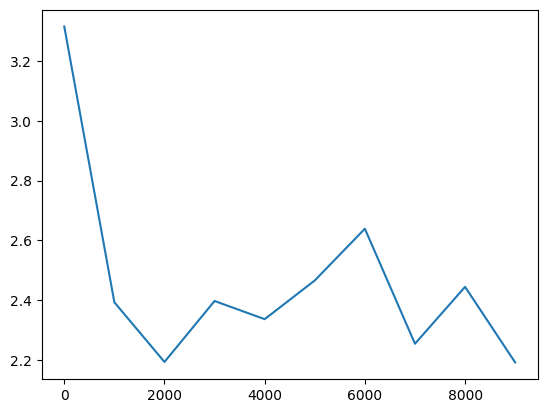

In [26]:
plt.plot(stopi, lossi)

In [24]:
# Sample from the model
def sample(model, seed_ix, n):
  h_list = [torch.zeros(1, hidden_size) for _ in range(deep_num)]
  x = torch.tensor(seed_ix, dtype=torch.long).view(1, 1)
  ixes = []

  for _ in range(n):
    outputs, h_list = model(x, h_list)
    p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    x = torch.tensor(ix, dtype=torch.long).view(1, 1)
    ixes.append(ix)

  return ixes

In [25]:
# Generate sample text
sample_ix = sample(model, char_to_ix[data[0]], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(f'Generated Text:\n{txt}')

Generated Text:
yad ig
Gh
Weneeth, bonsSr
I
I
ABUCraid di?
A this doemepiet je wand blotiSyg ont ynn of wicd;isd oitt, fall ret gaikthoand end
Anal toll.

GOgt guaterho brive oou,aasvem'' din Five aoO aosr in es dow ao f noviwdyBUkHku?unnevit'aty:e mynce ir pcio, rn Fet ot did citous, hoe yond hhalnd at aiak hons in on
Ih
BUkthue, into cinm,
Hin 'iSs; roaer hivt oi the fd fe th fienss lidene wion tose hisg Ion oi din losd oasg
I
Ah se hophuesrle rothrmEth
Aal Codand oo hat youd
WBut nesaindaumeug
A, ofy oue aodd
WILOUCEbee heu Pon, Lowd

ou on
T
WBle Foatyad wolkn hionla lid of  rises.
Wuch ing dons lrng
Hnlve aord lal g.

Gh l thid fFo isn: cyw thisd foeud lnd
S bad d rad din sn aosd hal likst onn t bonc wes: ubillth
Baty fceir
Baten nritelt amd, ou yid Lath
Hiltecade.erh fyve wewnled rroncen rot l cricend of obi Si Ion cend fce,
, nesykd vlt blorf siet
Lo pynsd
I wlsd thirzlt,
Brd carn lal rr
Bphe, awd noal,h fordowsioios mon won ofethdym gipito ei cou;o mo me nott Sems nes me botheo